In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

%matplotlib inline

2023-12-10 03:40:47.890467: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 03:40:47.890508: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-10 03:40:47.891547: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-10 03:40:47.896633: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-10 03:40:49.760041: W tensorflow/compiler/tf2

In [2]:
!ls

ConvLSTM_1_6_2
ConvLSTM_1_6_2.pt
ConvLSTM_ATT_future2_past6_1.pt
features_selection
img
LSTM.ipynb
LSTM_torch.ipynb
pipeline.ipynb
pipeline.py
README.md
temperatures_forecast_CNN-LSTM-Attention_Pohang-si.png
temperatures_forecast_CNN+LSTM+ATT_Pohang-si.png
temperatures_forecast_CNN+LSTM_Pohang-si.png
temperatures_forecast_CNN-LSTM_Pohang-si.png
temperatures_forecast_CNN_Pohang-si.png


In [3]:
# Replace 'your_file.csv' with the actual filename
file_path = [f'features_selection/data/features_{i}_19402023.csv' for i in range(5)]

def load_and_preprocess_data(file_path):
    """
    Load the dataset from the given file path and perform preprocessing steps.
    """
    if isinstance(file_path, list):
      df = pd.read_csv(file_path[0])
      for i in file_path[1:]:
        df = pd.concat([df, pd.read_csv(i)], axis=0)
      df = df.drop(['g', 'sst'], axis=1)
    else:
      df = pd.read_csv(file_path)
      df.sort_values(by=['time','latitude','longitude'])
      df = df.drop(["g"], axis=1)
      df = df.interpolate()
      df = df.dropna()

      for col in df.select_dtypes(include='float64').columns:
        df[col] = df[col].astype('float32', copy=False)

    return df

df = load_and_preprocess_data(file_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3594276 entries, 0 to 718854
Data columns (total 11 columns):
 #   Column     Dtype  
---  ------     -----  
 0   time       object 
 1   latitude   float64
 2   longitude  float64
 3   10u        float64
 4   10v        float64
 5   100u       float64
 6   100v       float64
 7   msl        float64
 8   swvl1      float64
 9   geo500     float64
 10  2t         float64
dtypes: float64(10), object(1)
memory usage: 329.1+ MB


In [4]:
df

,time,latitude,longitude,10u,10v,100u,100v,msl,swvl1,geo500,2t
0,1940-01-01 00:00:00,38.0,125.00,0.419251,-6.994049,0.539322,-7.767197,102701.690,0.000002,54024.832,-2.504486
1,1940-01-01 00:00:00,38.0,125.25,0.267883,-5.567291,0.401627,-6.972275,102700.440,0.182467,54007.832,-4.463470
2,1940-01-01 00:00:00,38.0,125.50,0.320618,-4.622955,0.482681,-6.185165,102706.690,0.229876,53989.582,-6.065033
3,1940-01-01 00:00:00,38.0,125.75,0.107727,-4.240143,0.275650,-5.673447,102706.190,0.208132,53971.082,-6.861908
4,1940-01-01 00:00:00,38.0,126.00,0.156555,-3.693268,0.290298,-5.080673,102703.690,0.293429,53953.582,-7.449799
...,...,...,...,...,...,...,...,...,...,...,...
718850,2023-11-19 12:00:00,34.0,129.00,10.564636,-3.080109,11.930634,-3.466751,101845.875,0.000005,55508.690,16.389801
718851,2023-11-19 12:00:00,34.0,129.25,10.969910,-2.972687,12.307587,-3.304642,101832.625,0.000005,55488.190,16.299957
718852,2023-11-19 12:00:00,34.0,129.50,10.767761,-2.702179,12.258759,-3.010696,101818.625,0.000005,55467.940,16.333160
718853,2023-11-19 12:00:00,34.0,129.75,11.442566,-2.366242,12.838837,-2.653275,101801.625,0.000005,55448.690,16.514801


In [5]:
df_av_month = df.copy()
df_av_month['time'] = pd.to_datetime(df_av_month['time']).dt.to_period('M')
df_av_month = df_av_month.groupby(['time','latitude','longitude']).mean().reset_index().sort_values(by=['time', 'latitude', 'longitude'])
df_av_month

,time,latitude,longitude,10u,10v,100u,100v,msl,swvl1,geo500,2t
0,1940-01,34.0,125.00,3.109276,-6.966926,3.416429,-7.617951,102041.055500,0.000002,53475.03180,3.971347
1,1940-01,34.0,125.25,3.254979,-7.084505,3.583031,-7.763556,102020.430500,0.000002,53457.15680,3.998691
2,1940-01,34.0,125.50,3.445702,-7.237923,3.785765,-7.901642,101997.530500,0.000002,53440.45680,4.070566
3,1940-01,34.0,125.75,3.635838,-7.284895,4.025413,-8.021954,101975.205500,0.000002,53422.65680,4.018027
4,1940-01,34.0,126.00,3.873924,-7.324837,4.305492,-8.090411,101950.680500,0.000002,53405.38180,4.145175
...,...,...,...,...,...,...,...,...,...,...,...
359494,2023-11,38.0,129.00,6.074238,0.989002,7.530390,1.212111,101801.609375,0.000004,55013.37825,11.436935
359495,2023-11,38.0,129.25,7.215717,-0.111340,8.244989,-0.191332,101796.859375,0.000004,54990.31575,12.330246
359496,2023-11,38.0,129.50,7.551777,-0.940319,8.650873,-1.085985,101783.203125,0.000004,54970.90950,12.700607
359497,2023-11,38.0,129.75,7.590595,-1.631847,8.827387,-1.780443,101771.328125,0.000004,54954.50325,12.885666


In [6]:
df = df_av_month

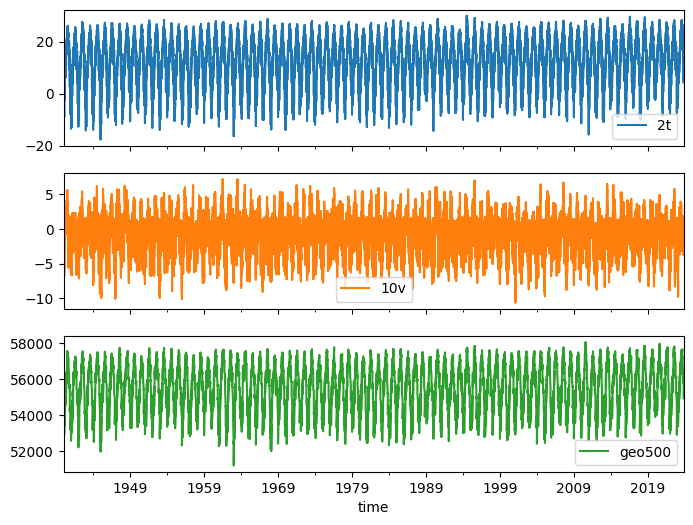

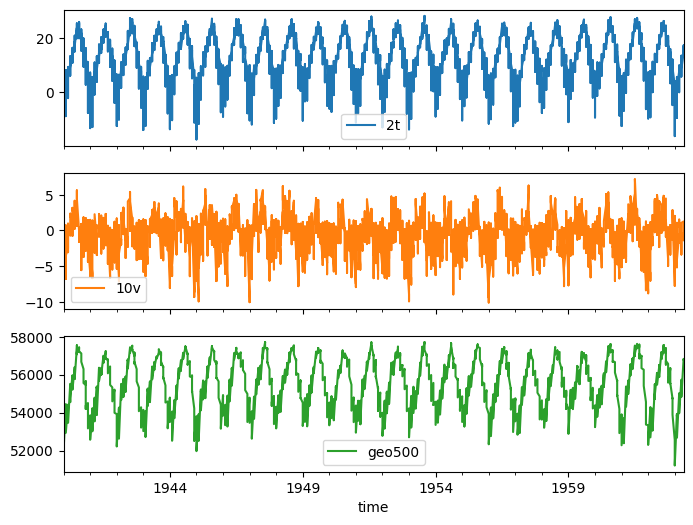

In [7]:
#date_time = pd.to_datetime(df_av_month['time'], format='%Y.%m')

plot_cols = ['2t', '10v', 'geo500']
plot_features = df_av_month[plot_cols]
plot_features.index = df_av_month['time']
_ = plot_features.plot(subplots=True)

plot_features = df_av_month[plot_cols][:100000]
plot_features.index = df_av_month['time'][:100000]
_ = plot_features.plot(subplots=True)

In [8]:
from tqdm import tqdm

# Extract relevant columns
lat = df['latitude'].unique()
print(f"Latitude: {lat.shape}")
lon = df['longitude'].unique()
print(f"Longitude: {lon.shape}")
features = ['10u', '10v','100u','100v','msl','swvl1','geo500','2t']
print(f"Features: {len(features)}")
timesteps = df['time'].unique()
print(f"Timestep: {timesteps.shape}")

# Create an empty 4D array
shape = (len(timesteps), len(lat), len(lon), len(features))
data_array = np.zeros(shape)

# Fill the array with data from the DataFrame
for i, lat_val in tqdm(enumerate(lat)):
  for j, lon_val in enumerate(lon):
    for k, feature in enumerate(features):
      subset = df[(df['longitude'] == lon_val) & (df['latitude'] == lat_val)]

      # Ensure that the subset has the same length as 'timesteps'
      assert len(subset) == len(timesteps), f"Warning: Length of subset ({len(subset)}) does not match timesteps ({len(timesteps)}) for lon={lon_val}, lat={lat_val}"

      data_array[:, i, j, k] = subset[feature].values

# Now, data_array is a 4D NumPy array with the shape (time, features, lat, lon)
f"Shape dataset : (Timesteps: {data_array.shape[0]}, Latitude: {data_array.shape[1]}, Longitude: {data_array.shape[2]}, Features: {data_array.shape[3]})"

Latitude: (17,)
Longitude: (21,)
Features: 8
Timestep: (1007,)


17it [00:01, 12.89it/s]


'Shape dataset : (Timesteps: 1007, Latitude: 17, Longitude: 21, Features: 8)'

In [9]:
data_array.shape

(1007, 17, 21, 8)

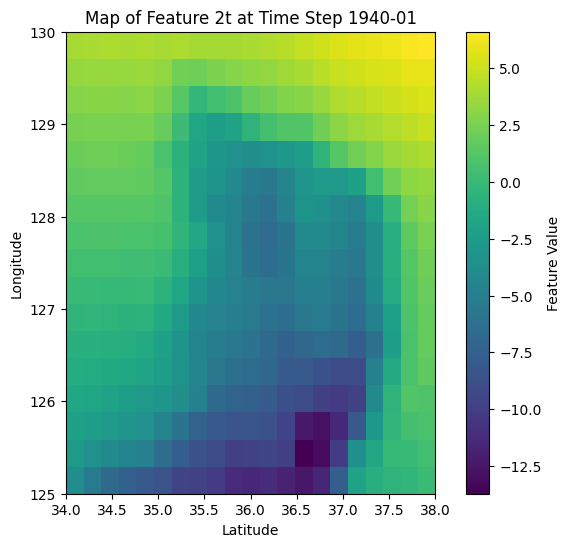

In [10]:
import matplotlib.pyplot as plt

# Example: Plotting a specific feature at a specific time step
feature_index = -1
time_step = 0

plt.imshow(data_array[time_step, :, :, feature_index], extent=(lat.min(), lat.max(), lon.min(), lon.max()))
plt.colorbar(label='Feature Value')
plt.title(f'Map of Feature {features[feature_index]} at Time Step {timesteps[time_step]}')
plt.ylabel('Longitude')
plt.xlabel('Latitude')
plt.show()

Shape of X: (17, 21)
Shape of Y: (17, 21)
Shape of C: (17, 21)


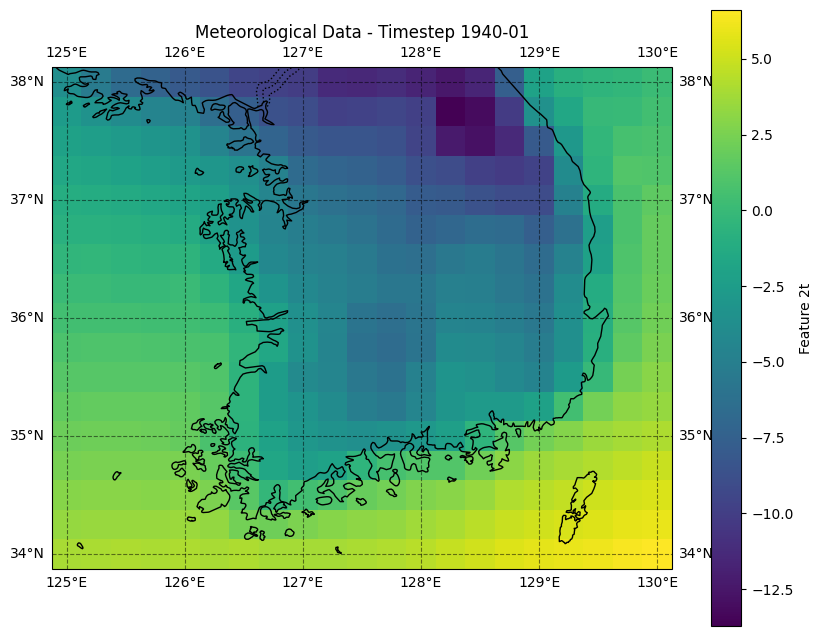

In [11]:
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import numpy as np

def plot_meteorological_data(lat, lon, data, feature_index, timestep, title="Meteorological Data"):
    """
    Plot meteorological data on a map using Cartopy.

    Parameters:
    - lon: 1D array, longitude values
    - lat: 1D array, latitude values
    - data: 4D array, meteorological data (time, features, lat, lon)
    - feature_index: int, the index of the meteorological feature being plotted
    - timestep: int, the index of the timestep to be plotted
    - title: str, title of the plot (default is "Meteorological Data")
    """
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 8))

    # Reshape data for pcolormesh
    X, Y = np.meshgrid(lon, lat)
    C = data[timestep, :, :, feature_index]

    print(f"Shape of X: {X.shape}")
    print(f"Shape of Y: {Y.shape}")
    print(f"Shape of C: {C.shape}")

    # Plot the meteorological data
    im = ax.pcolormesh(X, Y, C, cmap='viridis', transform=ccrs.PlateCarree(), shading='auto')

    # Add coastlines and country borders
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')

    # Add gridlines
    ax.gridlines(draw_labels=True, linestyle='--', color='black', alpha=0.5)

    # Add a colorbar
    cbar = plt.colorbar(im, ax=ax, label=f"Feature {features[feature_index]}")

    # Set plot title
    plt.title(f"{title} - Timestep {timesteps[time_step]}")

    # Show the plot
    plt.show()

# Example usage:
plot_meteorological_data(lat, lon, data_array, -1, 0)


In [12]:
def split_data(data):
    """
    Function to split time series data into train, val and test set.
    Respectively : 70% / 20% / 10%
    """
    num_timesteps=data.shape[0]
    train_array = data[0:int(num_timesteps*0.7), :, :, :]
    val_array = data[int(num_timesteps*0.7):int(num_timesteps*0.9), :, :, :]
    test_array = data[int(num_timesteps*0.9):, :, :, :]

    return train_array, val_array, test_array

train_array, val_array, test_array = split_data(data_array)
print(f"Train size: {train_array.shape}")
print(f"Val size: {val_array.shape}")
print(f"Test size: {test_array.shape}")

Train size: (704, 17, 21, 8)
Val size: (202, 17, 21, 8)
Test size: (101, 17, 21, 8)


In [13]:
def scale(train_array, val_array, test_array):
    """
    Function to scale the entire dataset in place using the mean and standard deviation of the training data only.
    """
   # Example shapes
    train_shape = train_array.shape  # (704, 17, 21, 8)
    val_shape = val_array.shape      # (202, 17, 21, 8)
    test_shape = test_array.shape    # (101, 17, 21, 8)

    # Reshape to 2D
    train_reshaped = train_array.reshape(-1, train_shape[-1])
    val_reshaped = val_array.reshape(-1, val_shape[-1])
    test_reshaped = test_array.reshape(-1, test_shape[-1])

    # Initialize and fit StandardScaler on the training data
    std_scaler = StandardScaler()
    train_scaled = std_scaler.fit_transform(train_reshaped)

    # Transform the validation and test data
    val_scaled = std_scaler.transform(val_reshaped)
    test_scaled = std_scaler.transform(test_reshaped)

    # Reshape back to original 4D shape
    train_scaled = train_scaled.reshape(train_shape)
    val_scaled = val_scaled.reshape(val_shape)
    test_scaled = test_scaled.reshape(test_shape)

    return train_scaled, val_scaled, test_scaled, std_scaler

scaled_train_array, scaled_val_array, scaled_test_array, std_scaler = scale(train_array, val_array, test_array)

In [14]:
scaled_train_array.transpose(0, 3, 1, 2).shape

(704, 8, 17, 21)

In [15]:
def unscale(scaled_data, original_shape, std_scaler):
    """
    Function to inverse scaling of data in place by using the mean and standard deviation of the training data only.
    """
    # mean and std computed only on training set
    # Reshape scaled data to 2D
    scaled_reshaped = scaled_data.reshape(-1, original_shape[-1])

    # Apply inverse_transform
    unscaled = std_scaler.inverse_transform(scaled_reshaped)

    # Reshape back to original 4D shape
    unscaled = unscaled.reshape(original_shape)

    return unscaled

In [16]:
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, data, window):
        self.data = torch.tensor(data, dtype=torch.float32).permute(0, 3, 1, 2)  # Reorganize the dimensions to have [batch_size, channels, height, width]

        self.window = window

    def __len__(self):
        return len(self.data) - self.window.total_window_size + 1

    def __getitem__(self, idx):
        window_data = self.data[idx:idx + self.window.total_window_size]
        inputs = window_data[self.window.input_slice]
        labels = window_data[self.window.labels_slice][:,-1,:,:]
        return inputs, labels

In [17]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_array, val_df=val_array, test_df=test_array,
               label_columns=None):
    # Store the raw data.
    self.train_array = train_array
    self.val_array = val_array
    self.test_array = test_array

    # Work out the label column indices.
    self.label_columns = label_columns
    self.column_indices = {name: i for i, name in
                           enumerate(features)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    # Meant to be used for extracting input samples from window
    self.input_slice = slice(0, input_width)
    # np.arange(5), creates an array from 0 to 4 (start=0, stop=5, step=1)
    # Generate input indices of a given window
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    # Meant to be used for extracting target samples from window
    self.labels_slice = slice(self.label_start, None)
    # Generate output indices of a given window
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

  def make_loader(self, data, batch_size, shuffle=True):
        dataset = TimeSeriesDataset(data, self)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
        return loader

In [18]:
# TODO : Find a city given its coordinates in an array of shape (lat, lon)

def plot(self, model=None, lon=0, lat=0, plot_col='2t', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, lat, lon, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    plt.scatter(self.label_indices, labels[n, :, lat, lon, :],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)

    if model is not None:
      predictions = model.predict(inputs)
      assert predictions.shape == labels.shape, f"Actual prediction shape: {predictions.shape}, Expected label shape: {labels.shape}"
      plt.scatter(self.label_indices, predictions[n, :, lat, lon, :],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [19]:
import torch
input_width = 12*6
output_width = 12*2
shift = 1

window_generator = WindowGenerator(input_width, output_width, shift, ['2t'])
train_loader = window_generator.make_loader(torch.tensor(scaled_train_array), 32)
val_loader = window_generator.make_loader(torch.tensor(scaled_val_array), 32)
test_loader = window_generator.make_loader(torch.tensor(scaled_test_array), 32, shuffle=False)

/tmp/ipykernel_3019962/204294383.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(data, dtype=torch.float32).permute(0, 3, 1, 2)  # Reorganize the dimensions to have [batch_size, channels, height, width]


In [20]:
print("Dimension of the past sequence: ", next(iter(train_loader))[0].shape)
print("Dimension of the future sequence: ", next(iter(train_loader))[1].shape)

Dimension of the past sequence:  torch.Size([32, 72, 8, 17, 21])
Dimension of the future sequence:  torch.Size([32, 24, 17, 21])


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
print(f'Training on {device}')

class ConvForecast(nn.Module):
    def __init__(self, num_features, map_height, map_width, num_future_steps):
        super(ConvForecast, self).__init__()

        self.map_height = map_height
        self.map_width = map_width
        self.num_future_steps = num_future_steps

        # Spatial feature extraction
        self.conv1 = nn.Conv2d(in_channels=num_features, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)

        # Adjust dimensions after maxpooling
        reduced_height = map_height // 2
        reduced_width = map_width // 2

        # Prediction layers
        self.fc1 = nn.Linear(32 * reduced_height * reduced_width, 64)
        self.fc2 = nn.Linear(64, num_future_steps * map_height * map_width)

    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()

        c_out = x.view(batch_size * timesteps, C, H, W)
        c_out = self.conv1(c_out)
        c_out = self.relu(c_out)
        c_out = self.maxpool(c_out)

        # Flatten the output for the fully connected layers
        c_out = c_out.reshape(batch_size * timesteps, -1)
        predictions = self.fc1(c_out)
        predictions = self.fc2(predictions)

        # Reshape and select only the last timestep
        predictions = predictions.view(batch_size, timesteps, -1)
        predictions = predictions[:, -1, :]

        # Reshape output to match desired forecast shape
        predictions = predictions.view(batch_size, self.num_future_steps, self.map_height, self.map_width)
        return predictions


Training on cpu


In [22]:
test_model = ConvForecast(8, 17, 21, 12).to(device)
test_model(next(iter(train_loader))[0]).shape

torch.Size([32, 12, 17, 21])

In [23]:
class ConvLSTM(nn.Module):
    def __init__(self, num_features, map_height, map_width, num_future_steps):
        super(ConvLSTM, self).__init__()

        self.map_height = map_height
        self.map_width = map_width
        self.num_future_steps = num_future_steps

        # Spatial feature extraction
        self.conv1 = nn.Conv2d(in_channels=num_features, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)

        # Temporal feature extraction
        self.lstm = nn.LSTM(input_size=32 * map_height * map_width, hidden_size=64, num_layers=1, batch_first=True, bidirectional=True)
    
        # Prediction layers
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_future_steps * map_height * map_width)

    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()

        c_in = x.reshape(batch_size * timesteps, C, H, W)
        #print("After reshape:", c_in.shape)
        c_out = self.conv1(c_in)
        #print("After conv:", c_out.shape)
        c_out = self.relu(c_out)
        #print("After relu:", c_out.shape)
        c_out = self.pool(c_out)
        #print("After pool:", c_out.shape)
        # Reshape for LSTM
        r_in = c_out.reshape(batch_size, timesteps, -1)
        #print("After reshape for lstm:", r_in.shape)
        r_out, (h_n, c_n) = self.lstm(r_in)
        

        # Predictions
        #print("After the lstm:", r_out.shape)
        r_out = r_out[:, -1, :]
        #print('After reshaping the dense later:', r_out.shape)
        r_out2 = self.fc1(r_out)
        #print("r_out2 shape:", r_out2.shape)
        output = self.fc2(r_out2)
        #print("output shape first:", output.shape)
        # Reshape output to match desired forecast shape
        output = output.view(batch_size, self.num_future_steps, self.map_height, self.map_width)
        #print("output shape:",output.shape)
        #print("output shape last:", output.shape)
        return output

In [24]:
test_model = ConvLSTM(8, 17, 21, 12).to(device)
test_model(next(iter(train_loader))[0])
print("a")

a


In [25]:
class ProbSparseAttentionLayer(nn.Module):
    def __init__(self, sampling_factor=5):
        super(ProbSparseAttentionLayer, self).__init__()
        self.sampling_factor = sampling_factor

    def forward(self, query_states, key_states, value_states):
        # get input sizes
        L_K = key_states.size(1)
        L_Q = query_states.size(1)
        log_L_K = np.ceil(np.log1p(L_K)).astype("int").item()
        log_L_Q = np.ceil(np.log1p(L_Q)).astype("int").item()

        # calculate a subset of samples to slice from K and create Q_K_sample
        U_part = min(self.sampling_factor * L_Q * log_L_K, L_K)

        # create Q_K_sample
        index_sample = torch.randint(0, L_K, (U_part,))
        K_sample = key_states[:, index_sample, :]
        Q_K_sample = torch.bmm(query_states, K_sample.transpose(1, 2))

        # calculate the query sparsity measurement
        M = Q_K_sample.max(dim=-1)[0] - torch.div(Q_K_sample.sum(dim=-1), L_K)

        # calculate u to find the Top-u queries
        u = min(self.sampling_factor * log_L_Q, L_Q)
        M_top = M.topk(u, sorted=False)[1]

        # calculate Q_reduce
        dim_for_slice = torch.arange(query_states.size(0)).unsqueeze(-1)
        Q_reduce = query_states[dim_for_slice, M_top]

        # canonical attention
        d_k = query_states.size(-1)
        attn_scores = torch.bmm(Q_reduce, key_states.transpose(-2, -1))
        attn_scores = attn_scores / d_k**(1/2)
        attn_probs = nn.functional.softmax(attn_scores, dim=-1)
        attn_output = torch.bmm(attn_probs, value_states)

        return attn_output, attn_probs

In [26]:
class ConvLSTM_ATT(nn.Module):
    def __init__(self, num_features, map_height, map_width, num_future_steps):
        super(ConvLSTM_ATT, self).__init__()

        self.map_height = map_height
        self.map_width = map_width
        self.num_future_steps = num_future_steps

        # Spatial feature extraction
        self.conv1 = nn.Conv2d(in_channels=num_features, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)

        # Temporal feature extraction
        self.lstm = nn.LSTM(input_size=32 * map_height * map_width, hidden_size=64, num_layers=1, batch_first=True, bidirectional=True)

        # Prob-Sparse Attention layer
        self.attention = ProbSparseAttentionLayer(sampling_factor=5)
        
        # Prediction layers
        self.fc1 = nn.Linear(3200, 64)
        self.fc2 = nn.Linear(64, num_future_steps * map_height * map_width)

    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()

        c_in = x.reshape(batch_size * timesteps, C, H, W)
        #print("After reshape:", c_in.shape)
        c_out = self.conv1(c_in)
        #print("After conv:", c_out.shape)
        c_out = self.relu(c_out)
        #print("After relu:", c_out.shape)
        c_out = self.pool(c_out)
        #print("After pool:", c_out.shape)
        # Reshape for LSTM
        r_in = c_out.reshape(batch_size, timesteps, -1)
        #print("After reshape for lstm:", r_in.shape)
        r_out, (h_n, c_n) = self.lstm(r_in)
        
        # Apply ProbSparse Attention
        probsparse_output, _ = self.attention(r_out, r_out, r_out)

        # Flatten the output for the fully connected layers
        probsparse_output = probsparse_output.reshape(probsparse_output.size(0), -1)

        # Prediction layers
        r_out2 = self.fc1(probsparse_output)
        output = self.fc2(r_out2)

        # Reshape output to match desired forecast shape
        output = output.view(batch_size, self.num_future_steps, self.map_height, self.map_width)
        return output

In [27]:
test_model = ConvLSTM_ATT(8, 17, 21, 12).to(device)
test_model(next(iter(train_loader))[0])
print("a")

a


In [28]:
# Parameters (placeholders, adjust according to your data)
num_features = 8  # Number of features per map coordinate (e.g., temp, wind speed)
num_timesteps = input_width  # Number of timesteps in each input sequence
num_future_steps = output_width  # Number of future time steps to predict
map_height = len(lat)  # Height of the map grid
map_width = len(lon)  # Width of the map grid

model_conv = ConvForecast(num_features, map_height, map_width, num_future_steps).to(device)
model_convlstm = ConvLSTM(num_features, map_height, map_width, num_future_steps).to(device)
model_att = ConvLSTM_ATT(num_features, map_height, map_width, num_future_steps).to(device)

# Optimizer and Loss function
optimizer_conv = optim.AdamW(model_conv.parameters(), lr=1e-3)
optimizer_convlstm = optim.AdamW(model_convlstm.parameters(), lr=1e-3)
optimizer_att = optim.AdamW(model_att.parameters(), lr=1e-3)
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression task

In [29]:
model_att = ConvLSTM_ATT(num_features, map_height, map_width, num_future_steps).to(device)
optimizer_att = optim.AdamW(model_att.parameters(), lr=1e-3)

In [30]:
import torch
from tqdm import tqdm
from copy import deepcopy

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3):
    train_losses = []
    val_losses = []
    no_improve_epochs = 0
    best_val_loss = float('inf')
    best_model = None

    for epoch in range(num_epochs):
        # Training loop
        model.train()  # Set the model to training mode
        train_loss = 0.0

        print(f'Epoch [{epoch+1}]:')
        for inputs, targets in tqdm(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = torch.sqrt(criterion(targets, outputs))

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
        train_losses.append(train_loss / len(train_loader.dataset))

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = torch.sqrt(criterion(targets, outputs))
                val_loss += loss.item() * inputs.size(0)
        val_losses.append(val_loss / len(val_loader.dataset))

        # Print epoch summary
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')

        # Check for improvement
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            no_improve_epochs = 0
            best_model = deepcopy(model)
            print('Validation loss decreased, updating best model.')
        else:
            no_improve_epochs += 1
            print(f'No improvement in validation loss for {no_improve_epochs} epochs.')

        if no_improve_epochs >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs.')
            break

    return best_model, train_losses, val_losses

In [31]:
# Call the training function
model_conv, conv_train_losses, conv_val_losses = train_model(model_conv, train_loader, val_loader, criterion, optimizer_conv, num_epochs=100, patience=5)

Epoch [1]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s]


Epoch 1/100, Train Loss: 0.9379, Validation Loss: 0.7752
Validation loss decreased, updating best model.
Epoch [2]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.81it/s]


Epoch 2/100, Train Loss: 0.5817, Validation Loss: 0.4341
Validation loss decreased, updating best model.
Epoch [3]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.85it/s]


Epoch 3/100, Train Loss: 0.3619, Validation Loss: 0.3366
Validation loss decreased, updating best model.
Epoch [4]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.85it/s]


Epoch 4/100, Train Loss: 0.2858, Validation Loss: 0.3050
Validation loss decreased, updating best model.
Epoch [5]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


Epoch 5/100, Train Loss: 0.2645, Validation Loss: 0.2901
Validation loss decreased, updating best model.
Epoch [6]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


Epoch 6/100, Train Loss: 0.2476, Validation Loss: 0.2642
Validation loss decreased, updating best model.
Epoch [7]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


Epoch 7/100, Train Loss: 0.2444, Validation Loss: 0.2555
Validation loss decreased, updating best model.
Epoch [8]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.09it/s]


Epoch 8/100, Train Loss: 0.2356, Validation Loss: 0.2736
No improvement in validation loss for 1 epochs.
Epoch [9]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.99it/s]


Epoch 9/100, Train Loss: 0.2394, Validation Loss: 0.2593
No improvement in validation loss for 2 epochs.
Epoch [10]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.95it/s]


Epoch 10/100, Train Loss: 0.2354, Validation Loss: 0.2636
No improvement in validation loss for 3 epochs.
Epoch [11]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.87it/s]


Epoch 11/100, Train Loss: 0.2340, Validation Loss: 0.2542
Validation loss decreased, updating best model.
Epoch [12]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


Epoch 12/100, Train Loss: 0.2272, Validation Loss: 0.2532
Validation loss decreased, updating best model.
Epoch [13]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


Epoch 13/100, Train Loss: 0.2373, Validation Loss: 0.2662
No improvement in validation loss for 1 epochs.
Epoch [14]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.00it/s]


Epoch 14/100, Train Loss: 0.2305, Validation Loss: 0.2655
No improvement in validation loss for 2 epochs.
Epoch [15]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s]


Epoch 15/100, Train Loss: 0.2221, Validation Loss: 0.2502
Validation loss decreased, updating best model.
Epoch [16]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.88it/s]


Epoch 16/100, Train Loss: 0.2226, Validation Loss: 0.2655
No improvement in validation loss for 1 epochs.
Epoch [17]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.83it/s]


Epoch 17/100, Train Loss: 0.2201, Validation Loss: 0.2523
No improvement in validation loss for 2 epochs.
Epoch [18]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


Epoch 18/100, Train Loss: 0.2207, Validation Loss: 0.2607
No improvement in validation loss for 3 epochs.
Epoch [19]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.79it/s]


Epoch 19/100, Train Loss: 0.2272, Validation Loss: 0.2454
Validation loss decreased, updating best model.
Epoch [20]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s]


Epoch 20/100, Train Loss: 0.2231, Validation Loss: 0.2449
Validation loss decreased, updating best model.
Epoch [21]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s]


Epoch 21/100, Train Loss: 0.2152, Validation Loss: 0.2517
No improvement in validation loss for 1 epochs.
Epoch [22]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]


Epoch 22/100, Train Loss: 0.2173, Validation Loss: 0.2399
Validation loss decreased, updating best model.
Epoch [23]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.81it/s]


Epoch 23/100, Train Loss: 0.2144, Validation Loss: 0.2406
No improvement in validation loss for 1 epochs.
Epoch [24]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s]


Epoch 24/100, Train Loss: 0.2099, Validation Loss: 0.2437
No improvement in validation loss for 2 epochs.
Epoch [25]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.87it/s]


Epoch 25/100, Train Loss: 0.2158, Validation Loss: 0.2502
No improvement in validation loss for 3 epochs.
Epoch [26]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.93it/s]


Epoch 26/100, Train Loss: 0.2108, Validation Loss: 0.2414
No improvement in validation loss for 4 epochs.
Epoch [27]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s]

Epoch 27/100, Train Loss: 0.2042, Validation Loss: 0.2475
No improvement in validation loss for 5 epochs.
Early stopping triggered after 27 epochs.


In [32]:
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0.0
    mae, mape, rmse = 0.0, 0.0, 0.0
    total_samples = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            # Calculate loss (like RMSE)
            loss = torch.sqrt(criterion(outputs, targets))
            test_loss += loss.item() * inputs.size(0)

            # Calculate MAE
            mae += torch.sum(torch.abs(outputs - targets)).item()

            # Calculate MAPE
            mape += torch.sum(torch.abs((targets - outputs) / targets)).item()

            # Calculate RMSE components (squared differences)
            rmse += torch.sum((outputs - targets) ** 2).item()

            total_samples += targets.numel()

    # Calculate mean values
    test_loss /= total_samples
    mae /= total_samples
    mape /= total_samples
    rmse = (rmse / total_samples) ** 0.5

    print(f'Test Loss (RMSE): {test_loss:.4f}')
    print(f'Mean Absolute Error (MAE): {mae:.4f}')
    print(f'Mean Absolute Percentage Error (MAPE): {mape:.4f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

In [33]:
evaluate_model(model_conv, test_loader)

Test Loss (RMSE): 0.0000
Mean Absolute Error (MAE): 0.2305
Mean Absolute Percentage Error (MAPE): 1.5605
Root Mean Squared Error (RMSE): 0.2895


In [34]:
# Call the training function
model_convlstm, convlstm_train_losses, convlstm_val_losses = train_model(model_convlstm, train_loader, val_loader, criterion, optimizer_convlstm, num_epochs=100, patience=5)

Epoch [1]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


Epoch 1/100, Train Loss: 0.9110, Validation Loss: 0.7171
Validation loss decreased, updating best model.
Epoch [2]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


Epoch 2/100, Train Loss: 0.5051, Validation Loss: 0.3479
Validation loss decreased, updating best model.
Epoch [3]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


Epoch 3/100, Train Loss: 0.2867, Validation Loss: 0.2526
Validation loss decreased, updating best model.
Epoch [4]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


Epoch 4/100, Train Loss: 0.2181, Validation Loss: 0.2219
Validation loss decreased, updating best model.
Epoch [5]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


Epoch 5/100, Train Loss: 0.2045, Validation Loss: 0.2162
Validation loss decreased, updating best model.
Epoch [6]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


Epoch 6/100, Train Loss: 0.1992, Validation Loss: 0.2231
No improvement in validation loss for 1 epochs.
Epoch [7]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


Epoch 7/100, Train Loss: 0.1946, Validation Loss: 0.2140
Validation loss decreased, updating best model.
Epoch [8]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


Epoch 8/100, Train Loss: 0.1910, Validation Loss: 0.2165
No improvement in validation loss for 1 epochs.
Epoch [9]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


Epoch 9/100, Train Loss: 0.1886, Validation Loss: 0.2145
No improvement in validation loss for 2 epochs.
Epoch [10]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


Epoch 10/100, Train Loss: 0.1855, Validation Loss: 0.2100
Validation loss decreased, updating best model.
Epoch [11]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


Epoch 11/100, Train Loss: 0.1819, Validation Loss: 0.2055
Validation loss decreased, updating best model.
Epoch [12]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


Epoch 12/100, Train Loss: 0.1793, Validation Loss: 0.2040
Validation loss decreased, updating best model.
Epoch [13]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


Epoch 13/100, Train Loss: 0.1768, Validation Loss: 0.2044
No improvement in validation loss for 1 epochs.
Epoch [14]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


Epoch 14/100, Train Loss: 0.1766, Validation Loss: 0.2023
Validation loss decreased, updating best model.
Epoch [15]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


Epoch 15/100, Train Loss: 0.1740, Validation Loss: 0.2004
Validation loss decreased, updating best model.
Epoch [16]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


Epoch 16/100, Train Loss: 0.1712, Validation Loss: 0.1999
Validation loss decreased, updating best model.
Epoch [17]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.05it/s]


Epoch 17/100, Train Loss: 0.1689, Validation Loss: 0.1924
Validation loss decreased, updating best model.
Epoch [18]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


Epoch 18/100, Train Loss: 0.1681, Validation Loss: 0.1899
Validation loss decreased, updating best model.
Epoch [19]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]


Epoch 19/100, Train Loss: 0.1673, Validation Loss: 0.1887
Validation loss decreased, updating best model.
Epoch [20]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


Epoch 20/100, Train Loss: 0.1656, Validation Loss: 0.1919
No improvement in validation loss for 1 epochs.
Epoch [21]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


Epoch 21/100, Train Loss: 0.1648, Validation Loss: 0.1929
No improvement in validation loss for 2 epochs.
Epoch [22]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


Epoch 22/100, Train Loss: 0.1636, Validation Loss: 0.1899
No improvement in validation loss for 3 epochs.
Epoch [23]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


Epoch 23/100, Train Loss: 0.1623, Validation Loss: 0.1905
No improvement in validation loss for 4 epochs.
Epoch [24]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]

Epoch 24/100, Train Loss: 0.1615, Validation Loss: 0.1929
No improvement in validation loss for 5 epochs.
Early stopping triggered after 24 epochs.


In [35]:
evaluate_model(model_convlstm, test_loader)

Test Loss (RMSE): 0.0000
Mean Absolute Error (MAE): 0.2027
Mean Absolute Percentage Error (MAPE): 1.4631
Root Mean Squared Error (RMSE): 0.2553


In [36]:
model_att, att_train_losses, att_val_losses = train_model(model_att, train_loader, val_loader, criterion, optimizer_att, num_epochs=100, patience=5)

Epoch [1]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


Epoch 1/100, Train Loss: 0.9987, Validation Loss: 0.9960
Validation loss decreased, updating best model.
Epoch [2]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


Epoch 2/100, Train Loss: 0.9834, Validation Loss: 0.9794
Validation loss decreased, updating best model.
Epoch [3]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


Epoch 3/100, Train Loss: 0.9729, Validation Loss: 0.9771
Validation loss decreased, updating best model.
Epoch [4]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


Epoch 4/100, Train Loss: 0.9718, Validation Loss: 0.9768
Validation loss decreased, updating best model.
Epoch [5]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


Epoch 5/100, Train Loss: 0.9712, Validation Loss: 0.9768
No improvement in validation loss for 1 epochs.
Epoch [6]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


Epoch 6/100, Train Loss: 0.9709, Validation Loss: 0.9768
No improvement in validation loss for 2 epochs.
Epoch [7]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


Epoch 7/100, Train Loss: 0.9710, Validation Loss: 0.9767
Validation loss decreased, updating best model.
Epoch [8]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


Epoch 8/100, Train Loss: 0.9718, Validation Loss: 0.9772
No improvement in validation loss for 1 epochs.
Epoch [9]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


Epoch 9/100, Train Loss: 0.9710, Validation Loss: 0.9766
Validation loss decreased, updating best model.
Epoch [10]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


Epoch 10/100, Train Loss: 0.9711, Validation Loss: 0.9763
Validation loss decreased, updating best model.
Epoch [11]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


Epoch 11/100, Train Loss: 0.9704, Validation Loss: 0.9753
Validation loss decreased, updating best model.
Epoch [12]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]


Epoch 12/100, Train Loss: 0.9355, Validation Loss: 0.8663
Validation loss decreased, updating best model.
Epoch [13]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.88it/s]


Epoch 13/100, Train Loss: 0.7589, Validation Loss: 0.8111
Validation loss decreased, updating best model.
Epoch [14]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


Epoch 14/100, Train Loss: 0.7052, Validation Loss: 0.7276
Validation loss decreased, updating best model.
Epoch [15]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


Epoch 15/100, Train Loss: 0.7019, Validation Loss: 0.7145
Validation loss decreased, updating best model.
Epoch [16]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.96it/s]


Epoch 16/100, Train Loss: 0.7013, Validation Loss: 0.7069
Validation loss decreased, updating best model.
Epoch [17]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


Epoch 17/100, Train Loss: 0.7026, Validation Loss: 0.7080
No improvement in validation loss for 1 epochs.
Epoch [18]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


Epoch 18/100, Train Loss: 0.7016, Validation Loss: 0.7065
Validation loss decreased, updating best model.
Epoch [19]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.91it/s]


Epoch 19/100, Train Loss: 0.7004, Validation Loss: 0.7055
Validation loss decreased, updating best model.
Epoch [20]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]


Epoch 20/100, Train Loss: 0.6970, Validation Loss: 0.6988
Validation loss decreased, updating best model.
Epoch [21]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


Epoch 21/100, Train Loss: 0.6722, Validation Loss: 0.6297
Validation loss decreased, updating best model.
Epoch [22]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]


Epoch 22/100, Train Loss: 0.6263, Validation Loss: 0.5805
Validation loss decreased, updating best model.
Epoch [23]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


Epoch 23/100, Train Loss: 0.5640, Validation Loss: 0.6372
No improvement in validation loss for 1 epochs.
Epoch [24]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


Epoch 24/100, Train Loss: 0.5147, Validation Loss: 0.6106
No improvement in validation loss for 2 epochs.
Epoch [25]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


Epoch 25/100, Train Loss: 0.4216, Validation Loss: 0.5629
Validation loss decreased, updating best model.
Epoch [26]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


Epoch 26/100, Train Loss: 0.3474, Validation Loss: 0.3219
Validation loss decreased, updating best model.
Epoch [27]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


Epoch 27/100, Train Loss: 0.2768, Validation Loss: 0.2939
Validation loss decreased, updating best model.
Epoch [28]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


Epoch 28/100, Train Loss: 0.2550, Validation Loss: 0.3044
No improvement in validation loss for 1 epochs.
Epoch [29]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


Epoch 29/100, Train Loss: 0.2586, Validation Loss: 0.2646
Validation loss decreased, updating best model.
Epoch [30]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.92it/s]


Epoch 30/100, Train Loss: 0.2507, Validation Loss: 0.2648
No improvement in validation loss for 1 epochs.
Epoch [31]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]


Epoch 31/100, Train Loss: 0.2350, Validation Loss: 0.2540
Validation loss decreased, updating best model.
Epoch [32]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


Epoch 32/100, Train Loss: 0.2413, Validation Loss: 0.2696
No improvement in validation loss for 1 epochs.
Epoch [33]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.02it/s]


Epoch 33/100, Train Loss: 0.2428, Validation Loss: 0.2883
No improvement in validation loss for 2 epochs.
Epoch [34]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


Epoch 34/100, Train Loss: 0.2323, Validation Loss: 0.3039
No improvement in validation loss for 3 epochs.
Epoch [35]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]


Epoch 35/100, Train Loss: 0.2403, Validation Loss: 0.2706
No improvement in validation loss for 4 epochs.
Epoch [36]:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.99it/s]

Epoch 36/100, Train Loss: 0.2334, Validation Loss: 0.2825
No improvement in validation loss for 5 epochs.
Early stopping triggered after 36 epochs.


In [37]:
evaluate_model(model_att, test_loader)

Test Loss (RMSE): 0.0001
Mean Absolute Error (MAE): 0.6614
Mean Absolute Percentage Error (MAPE): 3.9170
Root Mean Squared Error (RMSE): 0.8450


In [40]:
def unscale_temperatures(temperatures, std_scaler, feature_index=-1, num_features=8):
    # Create a dummy array with the same shape as the original data
    dummy_array = np.zeros((len(temperatures), num_features))
    
    dummy_array[:, feature_index] = temperatures

    # Apply inverse scaling
    unscaled_array = std_scaler.inverse_transform(dummy_array)

    # Extract the unscaled temperatures
    unscaled_temperatures = unscaled_array[:, feature_index]

    return unscaled_temperatures

Pohang-si


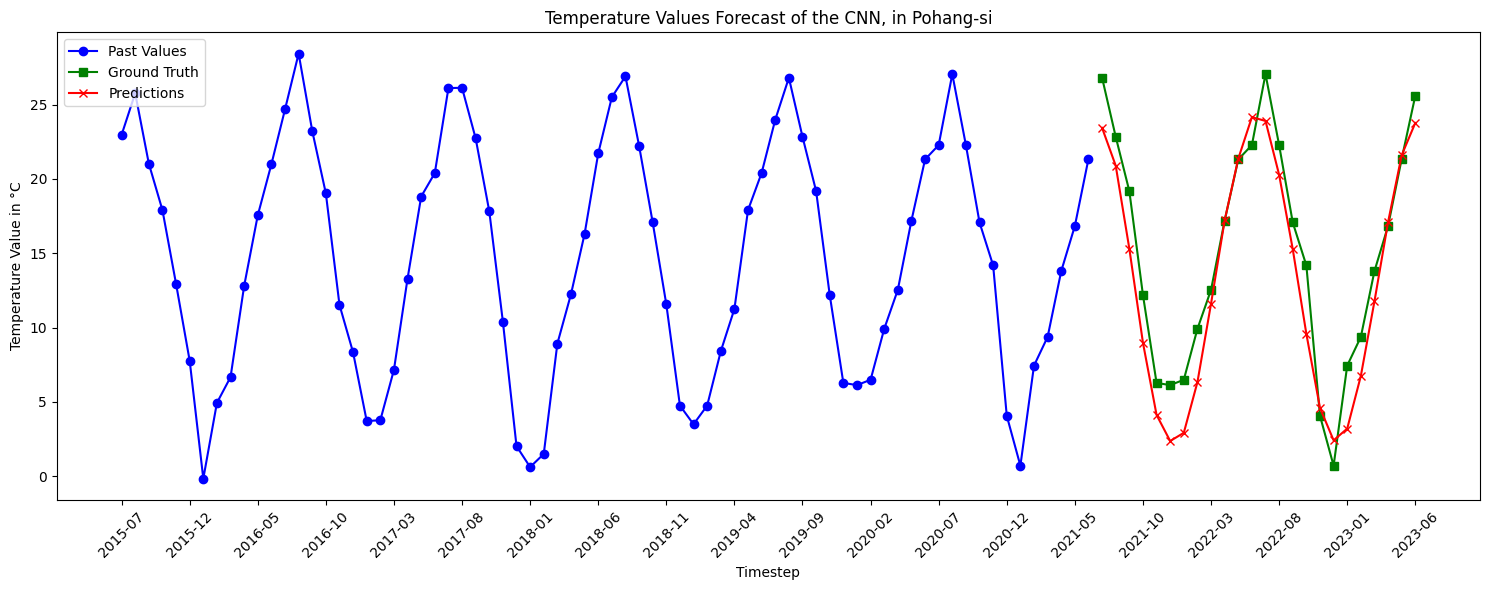

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from geopy.geocoders import Nominatim

def get_city_coordinates(lat, lon):
    geolocator = Nominatim(user_agent="weather forcasting")
    location = geolocator.reverse(f"{lat}, {lon}", language='en')
    address = location.raw['address']
    city = address.get('city', '')
    return city

def plot_temperature_values(loader, predictions, timesteps, lat, lon, input_width, output_width, batch_idx=0, lat_idx=0, lon_idx=0, model_name=""):
    city = get_city_coordinates(lat[lat_idx], lon[lon_idx])
    
    # Convert Period to datetime, then to strings or numeric timestamps for plotting
    formatted_timesteps = timesteps.to_timestamp().strftime('%Y-%m')

    # Calculate the start index for the test time periods
    test_start_idx = int(len(formatted_timesteps) * 0.9)

    # Calculate the timestep index range for the current batch
    # Each sequence in the DataLoader corresponds to a consecutive window in time
    current_batch_start = test_start_idx + batch_idx * (input_width + output_width)
    current_batch_end = current_batch_start + input_width + output_width

    # Extract the corresponding timestamps
    timesteps_sequence = timesteps[current_batch_start:current_batch_end]

    # Extract data for past and future timesteps
    past_data, ground_truth_data = loader
    past_temperatures = unscale_temperatures(past_data[batch_idx, :, -1, lat_idx, lon_idx], std_scaler)
    ground_truth_temperatures = unscale_temperatures(ground_truth_data[batch_idx, :, lat_idx, lon_idx], std_scaler)
    prediction_temperatures = unscale_temperatures(predictions.detach().numpy()[batch_idx, :, lat_idx, lon_idx], std_scaler)

    # Split the timestamps for past and future
    timesteps_past = formatted_timesteps[current_batch_start:current_batch_start + input_width]
    timesteps_future = formatted_timesteps[current_batch_start + input_width:current_batch_end]

    # Create scatter plot
    plt.figure(figsize=(15, 6))
    plt.plot(timesteps_past, past_temperatures, c='blue', marker='o', label='Past Values')
    plt.plot(timesteps_future, ground_truth_temperatures, c='green', marker='s', label='Ground Truth')
    plt.plot(timesteps_future, prediction_temperatures, c='red', marker='x', label='Predictions')

    # Set x-ticks to every third point and rotate labels
    plt.xticks(timesteps.to_timestamp().strftime('%Y-%m')[current_batch_start:current_batch_end:5], rotation=45)
    plt.xlabel('Timestep')
    plt.ylabel('Temperature Value in °C')

    print(get_city_coordinates(lat[lat_idx], lon[lon_idx]))

    plt.title(f'Temperature Values Forecast of the {model_name}, in {city}')
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.savefig(f"temperatures_forecast_{model_name}_{city}.png")
    plt.show()

# Usage example:
loader = next(iter(test_loader))
predictions = model_conv(loader[0])
plot_temperature_values(loader, predictions, timesteps, lat, lon, input_width, output_width, batch_idx=0, lat_idx=8, lon_idx=18, model_name="CNN")

Pohang-si


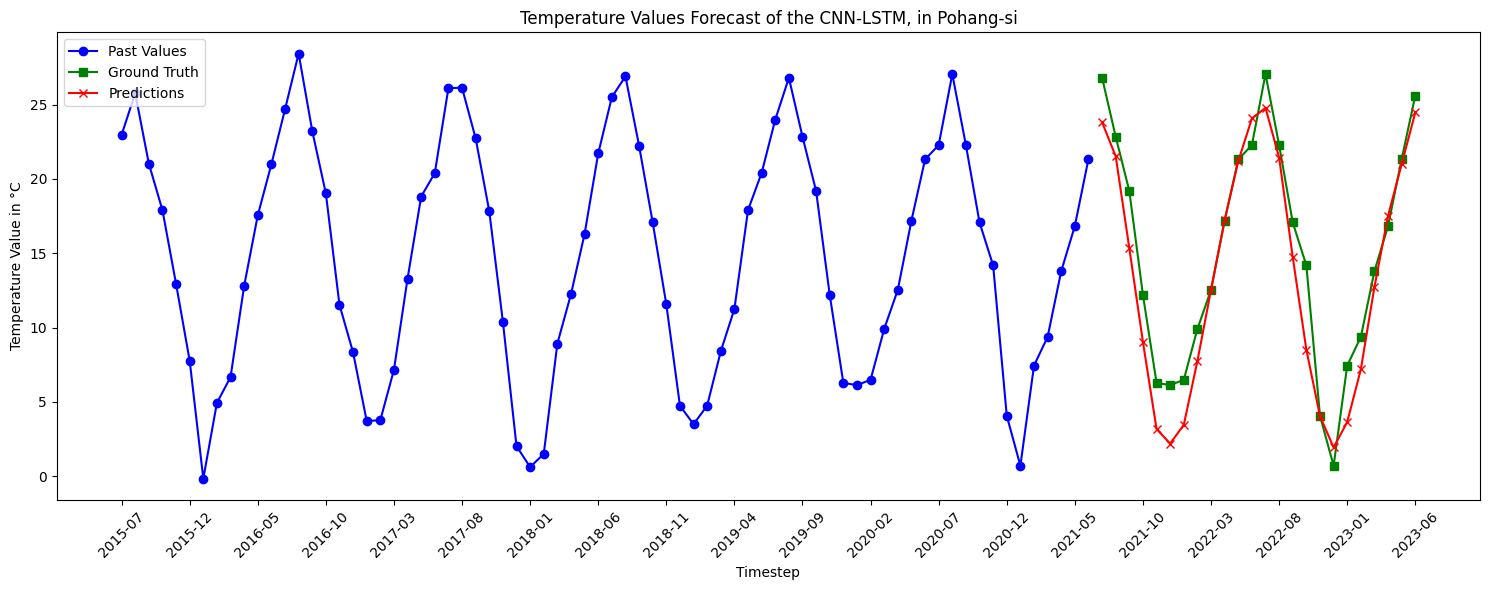

In [42]:
# Usage example:
loader = next(iter(test_loader))
predictions = model_convlstm(loader[0])
plot_temperature_values(loader, predictions, timesteps, lat, lon, input_width, output_width, batch_idx=0, lat_idx=8, lon_idx=18, model_name="CNN-LSTM")

Pohang-si


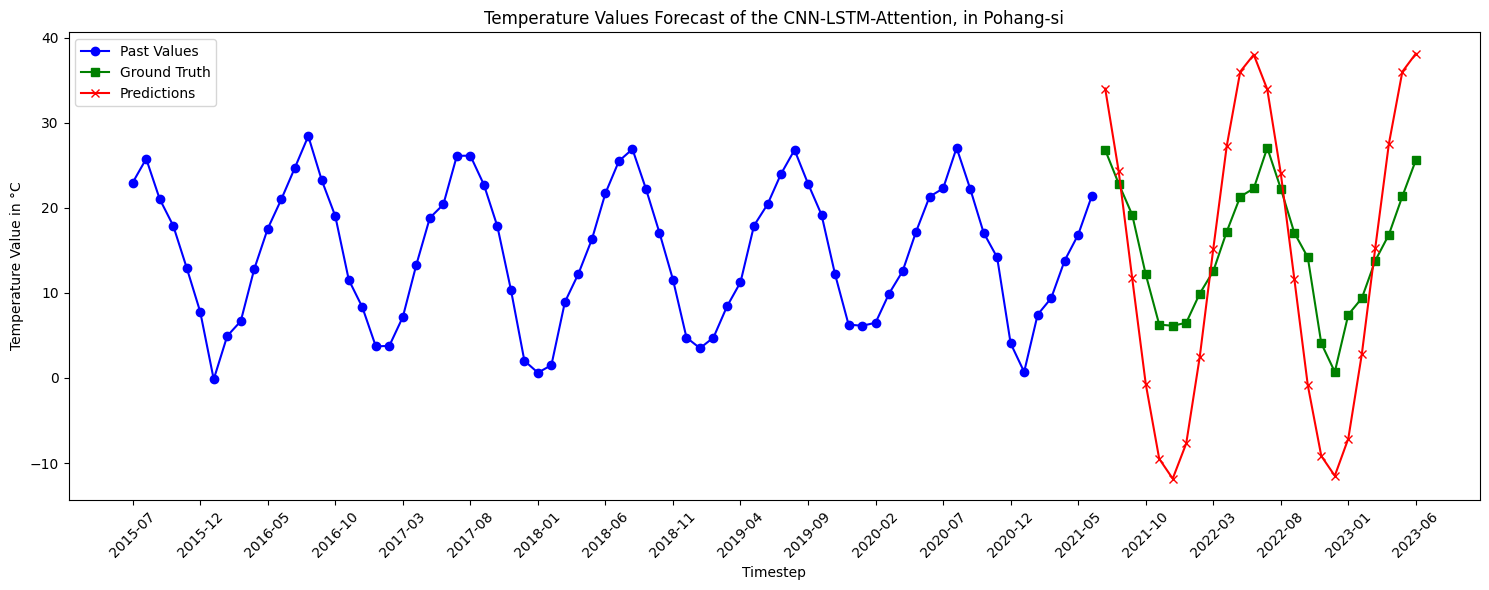

In [43]:
# Usage example:
loader = next(iter(test_loader))
predictions = model_att(loader[0])
plot_temperature_values(loader, predictions, timesteps, lat, lon, input_width, output_width, batch_idx=0, lat_idx=8, lon_idx=18, model_name="CNN-LSTM-Attention")

In [45]:
torch.save(model_conv, "Conv_1_6_2.pt")

In [46]:
torch.save(model_convlstm, "ConvLSTM_1_6_2.pt")

In [47]:
torch.save(model_att, "ConvLSTM_ATT_1_6_2.pt")